In [1]:
from pymldb import Connection
mldb = Connection("http://localhost")

#we'll need these also later!
import pandas as pd
import numpy as np
from IPython.display import display, HTML
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
from ipywidgets import interact

In [2]:
mldb.v1.datasets("bank").put({ 
    "type": "text.csv.tabular",
    "params": { 
        "dataFileUrl": 
            "archive+"+
            "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"+
            "#bank-additional/bank-additional-full.csv",
        "delimiter": ";"
    } 
})

<Response [201]>

In [3]:
mldb.query("select * from bank limit 10")

,age,campaign,cons.conf.idx,cons.price.idx,contact,day_of_week,default,duration,education,emp.var.rate,...,housing,job,loan,marital,month,nr.employed,pdays,poutcome,previous,y
_rowName,,,,,,,,,,,,,,,,,,,,,
000000022989,44,6,-36.1,93.444,cellular,mon,no,63,professional.course,1.4,...,yes,technician,no,married,aug,5228.1,999,nonexistent,0,no
000000012341,32,2,-42.7,93.918,telephone,fri,no,137,university.degree,1.4,...,no,admin.,yes,divorced,jul,5228.1,999,nonexistent,0,no
000000038427,30,2,-26.9,92.431,telephone,wed,no,196,university.degree,-3.4,...,yes,admin.,no,married,oct,5017.5,999,nonexistent,0,no
000000021757,33,3,-36.1,93.444,cellular,tue,no,173,university.degree,1.4,...,yes,self-employed,no,married,aug,5228.1,999,nonexistent,0,no
000000001125,59,2,-36.4,93.994,telephone,wed,unknown,81,basic.4y,1.1,...,no,retired,no,married,may,5191.0,999,nonexistent,0,no
000000031134,46,1,-46.2,92.893,cellular,wed,unknown,19,basic.6y,-1.8,...,no,blue-collar,no,married,may,5099.1,999,nonexistent,0,no
000000037727,28,1,-31.4,92.201,cellular,thu,no,64,professional.course,-2.9,...,yes,technician,no,single,aug,5076.2,999,nonexistent,0,no
000000025535,29,1,-42.0,93.200,cellular,wed,no,224,basic.9y,-0.1,...,no,technician,yes,single,nov,5195.8,999,nonexistent,0,no
000000015218,28,1,-42.7,93.918,cellular,thu,no,25,unknown,1.4,...,yes,blue-collar,no,single,jul,5228.1,999,nonexistent,0,no


In [15]:
training_procedure = mldb.v1.procedures("bank_exp")
training_procedure.put({
    "type": "classifier.experiment",
    "params": {
        "experimentName": "bank",
        "keepArtifacts": True,
        "training_dataset": { "id": "bank" },
        "testing_dataset": { "id": "bank" },
        "dataset_folds": [{
            "training_where": "rowHash() % 3 != 0",
            "testing_where": "rowHash() % 3 = 0",
        }],
        "modelFileUrlPattern": "file://models/bank.cls",
        "algorithm": "bbdt",
        "select": "* excluding (y, duration)",
        "label": "y='yes'",
        "outputAccuracyDataset": True,
        "mode": "boolean"
    }
})
result = training_procedure.runs.post({})
print "\nArea under ROC curve = %0.4f\n" % result.json()["status"]["folds"][0]["results"]["auc"]


Area under ROC curve = 0.7863



In [26]:
training_procedure.runs("2015-10-25T02:46:14.328745Z-5bc7042b732cb41f").details.get()

<Response [200]>

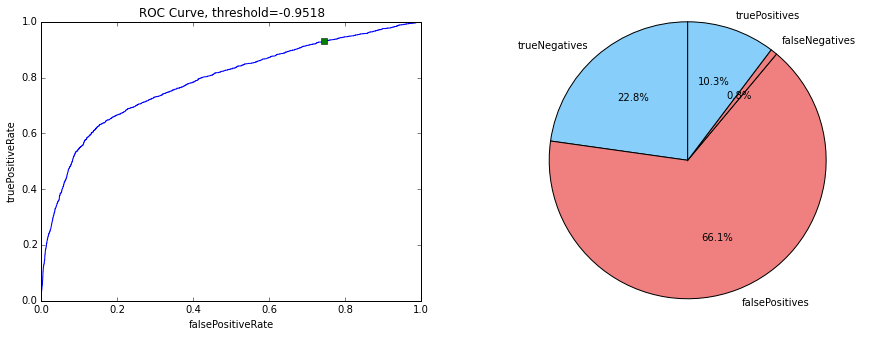

None

In [16]:
accuracy = mldb.query("select * from bank_results_0 order by score desc")

@interact
def accuracy_plot( threshold_index=[0,len(accuracy)-1]):
    row = accuracy.iloc[threshold_index]
    cols = ["trueNegatives","falsePositives","falseNegatives","truePositives",]
    f, (ax1, ax2) = plt.subplots(1, 2)
    
    accuracy.plot(ax=ax1, x="falsePositiveRate", y="truePositiveRate", 
    legend=False, title="ROC Curve, threshold=%.4f" % row.score).set_ylabel('truePositiveRate')
    ax1.plot(row.falsePositiveRate, row.truePositiveRate, 'gs')
    
    ax2.pie(row[cols], labels=cols, autopct='%1.1f%%', startangle = 90,
            colors=['lightskyblue','lightcoral','lightcoral', 'lightskyblue'])
    ax2.axis('equal')
    f.subplots_adjust(hspace=.75)
    plt.show()

In [17]:
explanation = mldb.v1.functions("bank_explainer")
explanation.put({ 
    "type": "classifier.explain",
    "params": { "modelFileUrl": "file://models/bank.cls" }
})

<Response [201]>

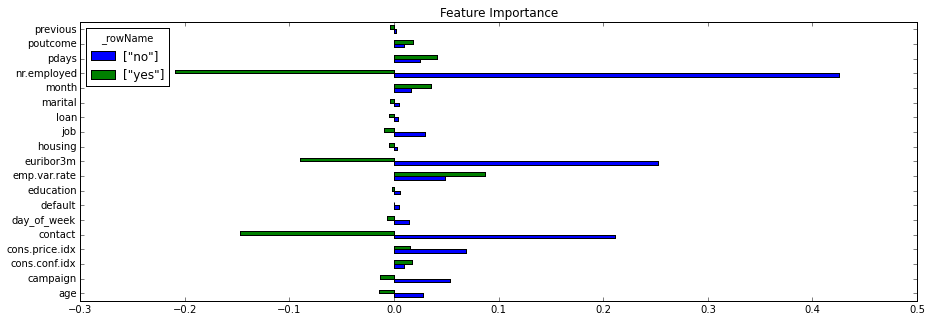

In [21]:
mldb.query("""
select avg(
    @bank_explainer(
        label: y='yes', 
        features: {*}
    )[explanation]
) as *
from bank
where rowHash() % 3 = 0
group by y
""").transpose().plot(kind='barh', title="Feature Importance")
plt.xticks(rotation=0)
plt.show()